# Title here

Description here

## Table of contents
- [1. Business undestanding](#business)
- [2. Data understanding](#data)
    - [2.1. Gathering data](#gather)
    - [2.2. Assessing data](#assess)
- [3. Prepare data](#prepare)
- [4. Data modeling](#model)
- [5. Evaluate the results](#eval)
- [6. Deploy](#deploy)

<a name="business"></a>
## 1. Business understanding

In this notebook we will try to address the following questions using data from [Stack Overflow Annual Developer Survey](https://insights.stackoverflow.com/survey).

> [What countries have more female respondants?](#q1)\
> [Are male respondants happier than female respondants?](#q2)\
> [What countries have the higher job satisfaction rates?](#q3)

The following sections serve as a guide in order to understand the data and what needs to be done in order to answer the questions above.

<a name="data"></a>
## 2. Data understanding

We begin our work by downloading the data that we will need in order to address the questions layed out in [Section 1.](#business). We will then proceed to taking a look at our data to get a sense of what needs to be changed later on

<a name="gather"></a>
   

<a name="gather"></a>
### 2.1. Gathering data

First, we need to download all the necessary data. In order to do so, we can run the line below to download all Stack Overflow surveys for all years:

In [ ]:
# Download survey data
%run -i '../download/download.py'

# Download shape files
%run -i '../download/shape.py'

These are all the surveys since 2011. We will only use the ones from the last five years. One of the reasons for doing so is that the structure of the survey changed and similar questions might not be comparable anymore. Next, in preparation for the next sections we can import the relevant libraries.

In [1]:
# Import libraries
import bar_chart_race as bcr
import imageio
import geopandas as gpd
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandarallel import pandarallel
from pycountry import countries
from tqdm.auto import tqdm
%matplotlib inline

In [2]:
# Set defaul style plot
plt.style.use('seaborn-white')

<a name="assess"></a>
### 2.2. Assessing data

Now that we have downloaded all the datasets let's start by reading the csvs from the past five years. In doing so, I am ignoring the first column as it serves as an ordered identifier for the respondants.

In [3]:
# Import survey data and skip first column
import warnings; warnings.simplefilter('ignore')
survey_2016 = pd.read_csv("../data/survey/survey_2016.csv").iloc[:, 1:]
survey_2017 = pd.read_csv("../data/survey/survey_2017.csv").iloc[:, 1:]
survey_2018 = pd.read_csv("../data/survey/survey_2018.csv").iloc[:, 1:]
survey_2019 = pd.read_csv("../data/survey/survey_2019.csv").iloc[:, 1:]
survey_2020 = pd.read_csv("../data/survey/survey_2020.csv").iloc[:, 1:]

# Import shapefile with geopandas
map_df = gpd.read_file("../data/shapefile/world_countries_2017.shp")

Great! Now we can quickly look at what these datasets look like. I will do that by picking two random samples from the survey.

In [4]:
# Show dataframe for two random samples for 2020
pd.options.display.max_columns = None # to show all columns
survey_2020.sample(2)

,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
63984,I am a developer by profession,Yes,NaN,14,NaN,NaN,NaN,Luxembourg,European Euro,EUR,Cassandra;DynamoDB;Elasticsearch;MongoDB;MySQL...,Elasticsearch;MongoDB;MySQL;PostgreSQL;Redis,Data scientist or machine learning specialist;...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,NaN,NaN,"Flex time or a flexible schedule;Languages, fr...",Slightly satisfied,"I’m not actively looking, but I am open to new...",JavaScript;Python;R;Ruby;Scala;SQL,Bash/Shell/PowerShell;C#;Java;Python;Ruby;Scal...,NaN,NaN,NaN,NaN,Yes,Extremely important,Very important,Better compensation;Better work/life balance;W...,"Read company media, such as employee blogs or ...",Once a year,NaN,Yes,NaN,Rarely: 1-2 days per year or less,NaN,NaN,NaN,NaN,NaN,"10,000 or more employees",Android;AWS;Docker;Heroku;iOS;Linux;MacOS;Slac...,AWS;Docker;Heroku;Linux;MacOS;Windows,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",Flask;Ruby on Rails,Flask;Ruby on Rails,NaN,40.0,17,9
8212,I am a developer by profession,Yes,26.0,15,Yearly,900000.0,12566.0,India,Indian rupee,INR,Cassandra;Elasticsearch;Firebase;IBM DB2;Mongo...,MongoDB;MySQL;Oracle,"Developer, back-end;Developer, desktop or ente...","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,South Asian,Man,"Flex time or a flexible schedule;Languages, fr...",Neither satisfied nor dissatisfied,I am actively looking for a job,Bash/Shell/PowerShell;Go;HTML/CSS;Java;JavaScr...,Bash/Shell/PowerShell;HTML/CSS;Java;JavaScript...,Apache Spark;Hadoop;Node.js;Pandas;TensorFlow,Apache Spark;Node.js;Pandas,Confluence;Jira;Github;Gitlab;Slack;Google Sui...,Confluence;Jira;Github;Gitlab;Slack;Google Sui...,Yes,Extremely important,Fairly important,Just because;Wanting to share accomplishments ...,"Read company media, such as employee blogs or ...",Once a year,Yes,Yes,Yes,Sometimes: 1-2 days per month but less than we...,NaN,"Hello, old friend",Stack Overflow (public Q&A for anyone who code...,Play games;Call a coworker or friend;Visit Sta...,Linux-based,"10,000 or more employees",Android;AWS;Docker;Google Cloud Platform;Herok...,Docker;Heroku;Linux;MacOS;Windows,I have little or no influence,Straight / Heterosexual,Yes,Neutral,Less than once per month or monthly,Multiple times per day,Easy,Too long,No,"Computer science, computer engineering, or sof...",Django;Flask;jQuery;Laravel;React.js;Spring;Vu...,Angular;jQuery;Spring,NaN,40.0,7,3


And for the remaining years we see:

In [5]:
# Random sample for 2019
survey_2019.sample(2)

,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,UnitTests,PurchaseHow,PurchaseWhat,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
56717,I am a developer by profession,No,Less than once a month but more than once per ...,The quality of OSS and closed source software ...,Employed full-time,Italy,No,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...","Taught yourself a new language, framework, or ...",2-9 employees,"Designer;Developer, desktop or enterprise appl...",20,16,14,Slightly dissatisfied,Neither satisfied nor dissatisfied,Somewhat confident,Yes,Not sure,"I’m not actively looking, but I am open to new...",1-2 years ago,Interview with people in peer roles;Interview ...,No,"Languages, frameworks, and other technologies ...",I was preparing for a job search,EUR,European Euro,2500.0,Monthly,34368.0,40.0,There's no schedule or spec; I work on what se...,Not enough people for the workload,Less than once per month / Never,Office,Average,"Yes, because I see value in code review",2.0,"No, but I think we should","The CTO, CIO, or other management purchase new...",I have some influence,C++;C#;Java;JavaScript;Objective-C;Swift,C++;C#;Java;Kotlin;Swift,SQLite,SQLite,Android;iOS;MacOS;Windows,Android;Windows,NaN,NaN,.NET;Xamarin,.NET;Xamarin,Android Studio;Visual Studio;Visual Studio Cod...,MacOS,I do not use containers,NaN,Useful for immutable record keeping outside of...,Yes,Yes,Yes,WhatsApp,In real life (in person),Screen Name,I don't remember,Daily or almost daily,Find answers to specific questions,More than 10 times per week,They were about the same,NaN,Yes,A few times per week,"No, I knew that Stack Overflow had a job board...","No, I've heard of them, but I am not part of a...",Neutral,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,41.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
86584,I am a developer by profession,Yes,Less than once per year,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Poland,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,"5,000 to 9,999 employees","Developer, full-stack;Educator",13,15,9,Slightly satisfied,Slightly satisfied,Somewhat confident,No,Not sure,"I’m not actively looking, but I am open to new...",3-4 years ago,"Write code by hand (e.g., on a whiteboard);Int...",No,"Languages, frameworks, and other technologies ...",I was preparing for a job search,PLN,Polish zloty,9520.0,Monthly,30528.0,46.0,There is a schedule and/or spec (made by me or...,Being tasked with non-development work;Distrac...,Less than once per month / Never,Office,Average,"Yes, because I see value in code review",7.0,"Yes, it's part of our process",Developers and management have nearly equal in...,I have some influence,HTML/CSS;Java;JavaScript;Python;SQL,Elixir;HTML/CSS;Java;Python;SQL;WebAssembly;Ot...,Oracle,MongoDB;Oracle;PostgreSQL;Other(s):,Docker;Linux;Windows;WordPress,Android;Docker;Google Cloud Platform;Linux;Ras...,jQuery;Spring,Angular/A

In [6]:
# Random sample for 2018
survey_2018.sample(2)

,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,HopeFiveYears,JobSearchStatus,LastNewJob,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,AssessJob10,AssessBenefits1,AssessBenefits2,AssessBenefits3,AssessBenefits4,AssessBenefits5,AssessBenefits6,AssessBenefits7,AssessBenefits8,AssessBenefits9,AssessBenefits10,AssessBenefits11,JobContactPriorities1,JobContactPriorities2,JobContactPriorities3,JobContactPriorities4,JobContactPriorities5,JobEmailPriorities1,JobEmailPriorities2,JobEmailPriorities3,JobEmailPriorities4,JobEmailPriorities5,JobEmailPriorities6,JobEmailPriorities7,UpdateCV,Currency,Salary,SalaryType,ConvertedSalary,CurrencySymbol,CommunicationTools,TimeFullyProductive,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,HackathonReasons,AgreeDisagree1,AgreeDisagree2,AgreeDisagree3,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,IDE,OperatingSystem,NumberMonitors,Methodology,VersionControl,CheckInCode,AdBlocker,AdBlockerDisable,AdBlockerReasons,AdsAgreeDisagree1,AdsAgreeDisagree2,AdsAgreeDisagree3,AdsActions,AdsPriorities1,AdsPriorities2,AdsPriorities3,AdsPriorities4,AdsPriorities5,AdsPriorities6,AdsPriorities7,AIDangerous,AIInteresting,AIResponsible,AIFuture,EthicsChoice,EthicsReport,EthicsResponsible,EthicalImplications,StackOverflowRecommend,StackOverflowVisit,StackOverflowHasAccount,StackOverflowParticipate,StackOverflowJobs,StackOverflowDevStory,StackOverflowJobsRecommend,StackOverflowConsiderMember,HypotheticalTools1,HypotheticalTools2,HypotheticalTools3,HypotheticalTools4,HypotheticalTools5,WakeTime,HoursComputer,HoursOutside,SkipMeals,ErgonomicDevices,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
77501,Yes,No,Czech Republic,No,"Independent contractor, freelancer, or self-em...",Some college/university study without earning ...,"Computer science, computer engineering, or sof...",NaN,Full-stack developer,6-8 years,6-8 years,Moderately satisfied,Moderately satisfied,Working as a founder or co-founder of my own c...,I am not interested in new job opportunities,More than 4 years ago,7.0,10.0,6.0,1.0,2.0,4.0,3.0,5.0,8.0,9.0,1.0,4.0,8.0,9.0,5.0,6.0,7.0,2.0,10.0,11.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I saw an employer’s advertisement,NaN,450000,NaN,21718.0,CZK,"Other chat system (IRC, proprietary software, ...",NaN,"Taught yourself a new language, framework, or ...",The official documentation and/or standards fo...,NaN,NaN,Agree,Neither Agree nor Disagree,Disagree,JavaScript;PHP;SQL;HTML;CSS,C++;Python,MySQL;MariaDB,Redis;Memcached;Elasticsearch,NaN,Linux,NaN,NaN,Sublime Text,Linux-based,1,NaN,Git,A few times per week,Yes,Yes,The ad-blocking software was causing display i...,Somewhat agree,Neither agree nor disagree,Somewhat agree,Stopped going to a website because of their ad...,5.0,3.0,6.0,7.0,2.0,1.0,4.0,NaN,Algorithms making important decisions,NaN,I'm excited about the possibilities more than ...,Depends on what it is,"Yes, but only within the company",Upper management at the company/organization,Unsure / I don't know,10 (Very Likely),Multiple times per day,Yes,Less than once per month or monthly,"No, I knew that Stack Overflow had a jobs boar...","No, and I don't know what that is",NaN,Yes,Somewhat interested,Very interested,Extremely interested,Very interested,Extremely interested,Between 9:01 - 10:00 AM,9 - 12 hours,30 - 59 minutes,Never,Ergonomic keyboard or mouse,I don't typically exercise,Male,Straight or heterosexual,"Secondary school (e.g. American high school, G...",White or of European descent,25 - 34 years old,No,NaN,The survey was an appropriate length,Very easy
74349,Yes,No,France,"Yes, full-time","Independent contractor, freelancer, or self-e

In [7]:
# Random sample for 2017
survey_2017.sample(2)

,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,YearsCodedJobPast,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType,CareerSatisfaction,JobSatisfaction,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive,PronounceGIF,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,JobSeekingStatus,HoursPerWeek,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,ImportantBenefits,ClickyKeys,JobProfile,ResumePrompted,LearnedHiring,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,Currency,Overpaid,TabsSpaces,EducationImportant,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,CousinEducation,WorkStart,HaveWorkedLanguage,WantWorkLanguage,HaveWorkedFramework,WantWorkFramework,HaveWorkedDatabase,WantWorkDatabase,HaveWorkedPlatform,WantWorkPlatform,IDE,AuditoryEnvironment,Methodology,VersionControl,CheckInCode,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,MetricAssess,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowDescribes,StackOverflowSatisfaction,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
21873,Professional developer,"Yes, I program as a hobby",Russian Federation,No,Employed full-time,Master's degree,Computer science or software engineering,A few days each month,20 to 99 employees,I prefer not to answer,14 to 15 years,11 to 12 years,NaN,Web developer,Full stack Web developer,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"With a hard ""g,"" like ""gift""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"I'm not actively looking, but I am open to new...",1.0,More than 4 years ago,Very important,Somewhat important,Very important,Not at all important,Somewhat important,Somewhat important,Very important,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Stock options; Vacation/days off; Health benef...,Yes,LinkedIn,A recruiter contacted me,"A friend, family member, or former colleague t...",Somewhat important,Not at all important,Important,Not very important,Not at all important,Very important,Very important,Not at all important,Not at all important,Somewhat important,NaN,NaN,Both,NaN,NaN,NaN,NaN,NaN,6:00 AM,Java,C; C++; Common Lisp; JavaScript,NaN,AngularJS; Hadoop; Node.js,MongoDB; PostgreSQL; Oracle,MongoDB; Redis,Linux Desktop; Mac OS,Android,Atom; IntelliJ; NetBeans,Turn on the news or talk radio,A

In [8]:
# Random sample for 206
survey_2016.sample(2)

,collector,country,un_subregion,so_region,age_range,age_midpoint,gender,self_identification,occupation,occupation_group,experience_range,experience_midpoint,salary_range,salary_midpoint,big_mac_index,tech_do,tech_want,aliens,programming_ability,employment_status,industry,company_size_range,team_size_range,women_on_team,remote,job_satisfaction,job_discovery,dev_environment,commit_frequency,hobby,dogs_vs_cats,desktop_os,unit_testing,rep_range,visit_frequency,why_learn_new_tech,education,open_to_new_job,new_job_value,job_search_annoyance,interview_likelihood,how_to_improve_interview_process,star_wars_vs_star_trek,agree_tech,agree_notice,agree_problemsolving,agree_diversity,agree_adblocker,agree_alcohol,agree_loveboss,agree_nightcode,agree_legacy,agree_mars,important_variety,important_control,important_sameend,important_newtech,important_buildnew,important_buildexisting,important_promotion,important_companymission,important_wfh,important_ownoffice,developer_challenges,why_stack_overflow
7335,Facebook,Sweden,Northern Europe,Western Europe,30-34,32.0,Male,Developer; Sr. Developer; Rockstar; Full-stack...,Full-stack web developer,Full-stack web developer,11+ years,13.0,"$40,000 - $50,000",45000.0,5.23,Arduino / Raspberry Pi; AngularJS; JavaScript;...,Android; Arduino / Raspberry Pi; AngularJS; C#...,Yes,8.0,Freelance / Contractor,Internet,1-4 employees,1-4 people,0,I rarely work remotely,I'm somewhat satisfied with my job,I knew I wanted to work here. I sought out the...,Sublime; Eclipse,I never check-in or commit code,2-5 hours per week,Cats,Mac OS X,I don't know,I'm not sure,Multiple times a day,I'm curious,I'm self-taught; On-the-job training; Industry...,"I'm not actively looking, but I am open to new...",Salary; Tech stack; Work/life balance; Office ...,Writing my CV and keeping it updated,70%,Offer remote interviews (e.g. via video confer...,Star Wars,Agree somewhat,Agree somewhat,Agree completely,Agree somewhat,Disagree completely,Neutral,Neutral,Agree somewhat,Neutral,Disagree completely,This is somewhat important,This is somewhat important,I don't care about this,This is very important,This is somewhat important,This is somewhat important,This is somewhat important,This is somewhat important,This is somewhat important,I don't care about this,Unrealistic expectations; Non-technical manage...,To get help for my job; To give help to others...
55118,Twitter,United Kingdom,Northern Europe,Western Europe,30-34,32.0,Male,Developer; Programmer; Sr. Developer; Manager;...,Full-stack web developer,Full-stack web developer,11+ years,13.0,"$70,000 - $80,000",75000.0,4.22,C#; F#; JavaScript; Redis; SQL; SQL Server,ReactJS,Yes,6.0,Employed full-time,Other (please specify),100-499 employees,20+ people,3,Full-time remote,I love my job,"Other job website e.g. Indeed, Monster, Dice, ...",Atom; Notepad++; Sublime; Visual Studio,Multiple times a day,2-5 hours per week,Cats,Windows 10,Yes,"5,001 - 10,000",Once a day,To keep my skills up to date,I'm self-taught; On-the-job training; B.S. in ...,I am not interested in new job opportunities,Salary; Equity; Ability to make or influence i...,Searching for a job that seems interesting,40%,Be more flexible about interview scheduling; O...,Star Trek,Agree somewhat,Agree completely,Agree completely,Agree completely,Disagree completely,Agree somewhat,Agree somewhat,Agree somewhat,Disagree somewhat,Disagree completely,This is very important,This is very important,I don't care about this,This is very important,This is very important,This is very important,This is somewhat important,This is very important,This is very important,This is somewhat important,Unrealistic expectations; Limited resources,To get help for my job; To give help to others...


Now we have a better sense of what the data looks like, so we can proceed to picking the columns that we will need for the analysis, given the questions we outlines in [Section 1.](#business). These are the following:

The columns that indicate what language respondants want to learn are the following:
> Survey 2020: LanguageWorkedWith \
> Survey 2019: LanguageWorkedWith \
> Survey 2018: LanguageWorkedWith \
> Survey 2017: HaveWorkedLanguage \
> Survey 2016: tech_do

The columns that indicate how satisfied a respondant is with their job are:
> Survey 2020: JobSat \
> Survey 2019: JobSat \
> Survey 2018: JobSatisfaction \
> Survey 2017: JobSatisfaction \
> Survey 2016: job_satisfaction

The columns that indicate education status are the following:
> Survey 2020: EdLevel \
> Survey 2019: EdLevel \
> Survey 2018: FormalEducation \
> Survey 2017: FormalEducation \
> Survey 2016: education

The columns that indicate where the respondant lives are:
> Survey 2020: Country \
> Survey 2019: Country \
> Survey 2018: Country \
> Survey 2017: Country \
> Survey 2016: country

The columns that indicate what is the respondant's developer status are:
> Survey 2020: Gender \
> Survey 2019: Gender \
> Survey 2018: Gender \
> Survey 2017: Gender \
> Survey 2016: gender

The columns that indicate what is the respondant's employment status are:
> Survey 2020: Employment \
> Survey 2019: Employment \
> Survey 2018: Employment \
> Survey 2017: EmploymentStatus \
> Survey 2016: employment_status


Lastly, we can take a loop at the shapefiles we imported:

In [9]:
# Head of shapefiles
map_df.head()

,OBJECTID,CNTRY_NAME,CNTRY_CODE,BPL_CODE,geometry
0,1,Algeria,012,13010.0,"MULTIPOLYGON (((-2.05592 35.07370, -2.05675 35..."
1,2,Angola,024,12010.0,"MULTIPOLYGON (((12.79760 -4.41685, 12.79875 -4..."
2,3,In dispute South Sudan/Sudan,9999,99999.0,"POLYGON ((28.08408 9.34722, 28.03889 9.34722, ..."
3,4,Benin,204,15010.0,"MULTIPOLYGON (((1.93753 6.30122, 1.93422 6.299..."
4,5,Botswana,072,14010.0,"POLYGON ((25.16312 -17.77816, 25.16383 -17.778..."


So the countries are in the variable CNTRY_NAME. We will need to match these with our data and for that we will have to harmonize all the country names in [Section 3.](#prepare)

Given all of the above we can proceed to prepare our data!

<a name="prepare"></a>
## 3. Prepare data

Since we already know which columns we will need in order to answer our questions we can first start by droping columns that are not relevant to us:

In [10]:
# Put relevant variables in list
keep_2020 = ['JobSat', 'Country', 'Gender', 'Employment']
keep_2019 = ['JobSat', 'Country', 'Gender', 'Employment']
keep_2018 = ['JobSatisfaction', 'Country', 'Gender', 'Employment']
keep_2017 = ['JobSatisfaction', 'Country', 'Gender', 'EmploymentStatus']
keep_2016 = ['job_satisfaction', 'country', 'gender', 'employment_status']

# Keep only relevant variables
survey_2020 = survey_2020[keep_2020]
survey_2019 = survey_2019[keep_2019]
survey_2018 = survey_2018[keep_2018]
survey_2017 = survey_2017[keep_2017]
survey_2016 = survey_2016[keep_2016]

Nice! Now we can rename the columns so that all dataframes have the same names for variables

In [11]:
# Rename columns
survey_2020.rename(columns={'JobSat': 'job_satisfaction', 
                           'Country': 'country', 'Gender': 'gender', 
                           'Employment': 'employment'}, inplace = True)
survey_2019.rename(columns={'JobSat': 'job_satisfaction', 
                           'Country': 'country', 'Gender': 'gender', 
                           'Employment': 'employment'}, inplace = True)
survey_2018.rename(columns={'JobSatisfaction': 'job_satisfaction', 
                           'Country': 'country', 'Gender': 'gender', 
                           'Employment': 'employment'}, inplace = True)
survey_2017.rename(columns={'JobSatisfaction': 'job_satisfaction', 
                           'Country': 'country', 'Gender': 'gender', 
                           'EmploymentStatus': 'employment'}, inplace = True)
survey_2016.rename(columns={'job_satisfaction': 'job_satisfaction', 
                           'country': 'country', 'gender': 'gender', 
                           'employment_status': 'employment'}, inplace = True);

Let's now start the pandarallel session in order to be able to use pandas' methods in parallel.

In [12]:
# Initialize pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Now we need to harmonize the answers to different questions for all survey years in order to merge them and have a complete data set. Let's with some an easy one and look at the category for gender in each year.

In [13]:
# Print unique gender categories in 2020
survey_2020['gender'].unique()

array(['Man', nan, 'Woman',
       'Man;Non-binary, genderqueer, or gender non-conforming',
       'Non-binary, genderqueer, or gender non-conforming',
       'Woman;Non-binary, genderqueer, or gender non-conforming',
       'Woman;Man;Non-binary, genderqueer, or gender non-conforming',
       'Woman;Man'], dtype=object)

In [14]:
# Print unique gender categories in 2019
survey_2019['gender'].unique()

array(['Man', nan, 'Woman',
       'Non-binary, genderqueer, or gender non-conforming',
       'Woman;Non-binary, genderqueer, or gender non-conforming',
       'Woman;Man;Non-binary, genderqueer, or gender non-conforming',
       'Woman;Man',
       'Man;Non-binary, genderqueer, or gender non-conforming'],
      dtype=object)

In [15]:
# Print unique gender categories in 2018
survey_2018['gender'].unique()

array(['Male', nan, 'Female',
       'Female;Male;Transgender;Non-binary, genderqueer, or gender non-conforming',
       'Female;Male',
       'Male;Non-binary, genderqueer, or gender non-conforming',
       'Non-binary, genderqueer, or gender non-conforming', 'Transgender',
       'Female;Transgender',
       'Transgender;Non-binary, genderqueer, or gender non-conforming',
       'Female;Non-binary, genderqueer, or gender non-conforming',
       'Female;Transgender;Non-binary, genderqueer, or gender non-conforming',
       'Male;Transgender', 'Female;Male;Transgender',
       'Female;Male;Non-binary, genderqueer, or gender non-conforming',
       'Male;Transgender;Non-binary, genderqueer, or gender non-conforming'],
      dtype=object)

In [16]:
# Print unique gender categories in 2017
survey_2017['gender'].unique()

array(['Male', nan, 'Female', 'Gender non-conforming', 'Other',
       'Male; Gender non-conforming', 'Female; Transgender',
       'Male; Female', 'Male; Other', 'Transgender',
       'Transgender; Gender non-conforming',
       'Female; Gender non-conforming',
       'Male; Female; Transgender; Gender non-conforming; Other',
       'Male; Female; Transgender', 'Male; Female; Other',
       'Male; Female; Transgender; Gender non-conforming',
       'Male; Transgender', 'Female; Transgender; Gender non-conforming',
       'Gender non-conforming; Other',
       'Male; Female; Gender non-conforming', 'Female; Other',
       'Male; Transgender; Gender non-conforming', 'Transgender; Other',
       'Male; Gender non-conforming; Other',
       'Female; Gender non-conforming; Other',
       'Male; Female; Gender non-conforming; Other',
       'Female; Transgender; Other',
       'Female; Transgender; Gender non-conforming; Other',
       'Male; Transgender; Other', 'Male; Female; Transgender;

In [17]:
# Print unique gender categories in 2016
survey_2016['gender'].unique()

array(['Male', nan, 'Female', 'Prefer not to disclose', 'Other'],
      dtype=object)

Given what we see above, let's cluster all in the following four categories: female, male, other, nan. We can define a function to assing the value of Male, Female, Other or nan.

In [18]:
# Define function to uniform gender
def gender_uniform(value):
    """This function takes a gender string as argument
        and outputs uniform gender. It is meant to be
        applied to survey dataframes.
    """
    # Set value as string and lower case
    gender = str(value).lower()
    # Value if male or man
    if gender == 'male' or gender == 'man':
        output = 'Male'
    # Value if female or woman
    elif gender == 'female' or gender == 'woman':
        output = 'Female'
    # Assign null values
    elif gender == 'nan':
        output = np.nan
    # Other categories lumped into other
    else:
        output = 'Other'
    # Return output
    return(output)

# Define function to create gender dummy variables
def gender_dummy(df_raw):
    """This function takes a dataframe as input and creates gender
        dummy variables based on the gender variable.
    """
    # Get dummy variables
    df = pd.get_dummies(df_raw['gender'], dummy_na = True)
    # Rename variables
    df.rename(columns={"Female": "gender_female", "Male": "gender_male", "Other": "gender_other"}, inplace = True)
    df.columns = df.columns.fillna('gender_null')
    # Return gender dummy dataframe
    return(df)

# Apply function to uniform gender
survey_2020['gender'] = survey_2020['gender'].parallel_apply(lambda x: gender_uniform(x))
survey_2019['gender'] = survey_2019['gender'].parallel_apply(lambda x: gender_uniform(x))
survey_2018['gender'] = survey_2018['gender'].parallel_apply(lambda x: gender_uniform(x))
survey_2017['gender'] = survey_2017['gender'].parallel_apply(lambda x: gender_uniform(x))
survey_2016['gender'] = survey_2016['gender'].parallel_apply(lambda x: gender_uniform(x))

# Add dummy columns
survey_2020 = pd.concat([survey_2020, gender_dummy(survey_2020)], axis = 1, sort = False)
survey_2019 = pd.concat([survey_2019, gender_dummy(survey_2019)], axis = 1, sort = False)
survey_2018 = pd.concat([survey_2018, gender_dummy(survey_2018)], axis = 1, sort = False)
survey_2017 = pd.concat([survey_2017, gender_dummy(survey_2017)], axis = 1, sort = False)
survey_2016 = pd.concat([survey_2016, gender_dummy(survey_2016)], axis = 1, sort = False)

We can take a quick look at what the data looks like now:

In [19]:
survey_2020.sample(4)

,job_satisfaction,country,gender,employment,gender_female,gender_male,gender_other,gender_null
15089,Slightly dissatisfied,France,Male,Employed full-time,0,1,0,0
37898,NaN,Tunisia,NaN,Employed full-time,0,0,0,1
16192,Very satisfied,Argentina,Male,Employed full-time,0,1,0,0
18460,Slightly dissatisfied,Costa Rica,Male,Employed full-time,0,1,0,0


Similarly, for job satisfaction we can look at the possible values

In [20]:
# Print unique job satisfaction categories in 2020
survey_2020['job_satisfaction'].unique()

array(['Slightly satisfied', 'Very dissatisfied', nan,
       'Slightly dissatisfied', 'Very satisfied',
       'Neither satisfied nor dissatisfied'], dtype=object)

In [21]:
# Print unique job satisfaction categories in 2019
survey_2019['job_satisfaction'].unique()

array([nan, 'Slightly satisfied', 'Slightly dissatisfied',
       'Neither satisfied nor dissatisfied', 'Very satisfied',
       'Very dissatisfied'], dtype=object)

In [22]:
# Print unique job satisfaction categories in 2018
survey_2018['job_satisfaction'].unique()

array(['Extremely satisfied', 'Moderately dissatisfied',
       'Moderately satisfied', 'Neither satisfied nor dissatisfied',
       'Slightly satisfied', nan, 'Slightly dissatisfied',
       'Extremely dissatisfied'], dtype=object)

In [23]:
# Print unique job satisfaction categories in 2017
survey_2017['job_satisfaction'].unique()

array([nan,  9.,  3.,  8.,  6.,  7.,  5.,  4., 10.,  2.,  0.,  1.])

In [24]:
# Print unique job satisfaction categories in 2016
survey_2016['job_satisfaction'].unique()

array([nan, 'I love my job', "I don't have a job",
       "I'm somewhat satisfied with my job",
       "I'm somewhat dissatisfied with my job",
       "I'm neither satisfied nor dissatisfied", 'Other (please specify)',
       'I hate my job'], dtype=object)

We will try to lump all categories into six categories: Very satisfied, satisfied, Neither, Dissatisfied, Very Dissatisfied and nan. We will take a similar approach to gender and define a function to do this.

In [25]:
# Define function to harmonize job satisfaction
def jobsatisfaction_uniform(value):
    """This function takes a job satisfaction string as argument
        and outputs uniform job satisfactions. It is meant to be
        applied to survey dataframes.
    """
    # Set value as string and lower case
    job_satisfac = str(value).lower()
    # Values to match
    v_satisfied = ['very satisfied', 'extremely satisfied', 'i love my job', '10.0', '9.0']
    satisfied = ['slightly satisfied', 'moderately satisfied', 'i\'m somewhat satisfied with my job', '8.0', '7.0']
    neither = ['neither satisfied nor dissatisfied', 'i\'m neither satisfied nor dissatisfied', '6.0', '5.0', '4.0']
    dissatisfied = ['slightly dissatisfied', 'moderately dissatisfied', 'i\'m somewhat dissatisfied with my job', '3.0', '2.0']
    v_dissatisfied = ['very dissatisfied', 'extremely dissatisfied', 'i hate my job', '1.0', '0.0']
    # Value if very satisfied
    if job_satisfac in v_satisfied:
        output = 'Very satisfied'
    # Value if satisfied
    elif job_satisfac in satisfied:
        output = 'Satisfied'
    # Value if neither
    elif job_satisfac in neither:
        output = 'Neither'
    # Value if dissatisfied and assign binary variable
    elif job_satisfac in dissatisfied:
        output = 'Dissatisfied'
    # Value if very dissatisfied and assign binary variable
    elif job_satisfac in v_dissatisfied:
        output = 'Very dissatisfied'
    # Other categories become np.nan values
    else:
        output = np.nan
    # Return output
    return(output)

# Define function to create job satisfaction dummy variables
def jobsatisfaction_dummy(df_raw):
    '''This function takes a dataframe as input and creates job satisfaction
        dummy variables based on the job_satisfaction variable.
    '''
    # Get dummy variables
    df = pd.get_dummies(df_raw['job_satisfaction'], dummy_na = True)
    # Rename variables
    df.rename(columns={"Dissatisfied": "jobsat_disssatisfied", "Neither": "jobsat_neither", "Satisfied": "jobsat_satisfied", "Very dissatisfied": "jobsat_v_disssatisfied", "Very satisfied": "jobsat_v_satisfied"}, inplace = True)
    df.columns = df.columns.fillna('jobsat_null')
    # Return job satisfaction dummy dataframe
    return(df)
       
# Apply function to uniform job satisfaction
survey_2020['job_satisfaction'] = survey_2020['job_satisfaction'].parallel_apply(lambda x: jobsatisfaction_uniform(x))
survey_2019['job_satisfaction'] = survey_2019['job_satisfaction'].parallel_apply(lambda x: jobsatisfaction_uniform(x))
survey_2018['job_satisfaction'] = survey_2018['job_satisfaction'].parallel_apply(lambda x: jobsatisfaction_uniform(x))
survey_2017['job_satisfaction'] = survey_2017['job_satisfaction'].parallel_apply(lambda x: jobsatisfaction_uniform(x))
survey_2016['job_satisfaction'] = survey_2016['job_satisfaction'].parallel_apply(lambda x: jobsatisfaction_uniform(x))

# Add dummy columns
survey_2020 = pd.concat([survey_2020, jobsatisfaction_dummy(survey_2020)], axis = 1, sort = False)
survey_2019 = pd.concat([survey_2019, jobsatisfaction_dummy(survey_2019)], axis = 1, sort = False)
survey_2018 = pd.concat([survey_2018, jobsatisfaction_dummy(survey_2018)], axis = 1, sort = False)
survey_2017 = pd.concat([survey_2017, jobsatisfaction_dummy(survey_2017)], axis = 1, sort = False)
survey_2016 = pd.concat([survey_2016, jobsatisfaction_dummy(survey_2016)], axis = 1, sort = False)

We can also create a job satisfaction score that gives a score between 1 and 5 to each user. This will be used later on to plot a map of job satisfaction scores.

In [26]:
# Define function to assign satisfaction score
def satisfaction_score(value):
    """This function takes a job satisfaction string and translates it
        into a score
    """
    # Define score
    score = str(value).lower()
    # Score if very satisfied
    if score == 'very satisfied':
        output = 5
    # Score if satisfied
    elif score == 'satisfied':
        output = 4
    # Score if neither
    elif score == 'neither':
        output = 3
    # Score if dissatisfied
    elif score == 'dissatisfied':
        output = 2
    # Score if very dissatisfied
    elif score == 'very dissatisfied':
        output = 1
    else: # If value is null
        output = np.nan
    # Return desired output
    return(output)

# Apply function to get score
survey_2020['satisfaction_score'] = survey_2020['job_satisfaction'].parallel_apply(lambda x : satisfaction_score(x))
survey_2019['satisfaction_score'] = survey_2019['job_satisfaction'].parallel_apply(lambda x : satisfaction_score(x))
survey_2018['satisfaction_score'] = survey_2018['job_satisfaction'].parallel_apply(lambda x : satisfaction_score(x))
survey_2017['satisfaction_score'] = survey_2017['job_satisfaction'].parallel_apply(lambda x : satisfaction_score(x))
survey_2016['satisfaction_score'] = survey_2016['job_satisfaction'].parallel_apply(lambda x : satisfaction_score(x))

Again, we can see that this work by looking at a few rows:

In [27]:
survey_2017[['job_satisfaction', 'satisfaction_score']].head()

,job_satisfaction,satisfaction_score
0,NaN,NaN
1,NaN,NaN
2,Very satisfied,5.0
3,Dissatisfied,2.0
4,Satisfied,4.0


Next, let's look at the employment variables and how they are layed out

In [28]:
# Print unique employment categories in 2020
survey_2020['employment'].unique()

array(['Independent contractor, freelancer, or self-employed',
       'Employed full-time', nan, 'Student',
       'Not employed, but looking for work', 'Employed part-time',
       'Retired', 'Not employed, and not looking for work'], dtype=object)

In [29]:
# Print unique employment categories in 2019
survey_2019['employment'].unique()

array(['Not employed, and not looking for work',
       'Not employed, but looking for work', 'Employed full-time',
       'Independent contractor, freelancer, or self-employed', nan,
       'Employed part-time', 'Retired'], dtype=object)

In [30]:
# Print unique employment categories in 2018
survey_2018['employment'].unique()

array(['Employed part-time', 'Employed full-time',
       'Independent contractor, freelancer, or self-employed',
       'Not employed, and not looking for work',
       'Not employed, but looking for work', nan, 'Retired'], dtype=object)

In [31]:
# Print unique employment categories in 2017
survey_2017['employment'].unique()

array(['Not employed, and not looking for work', 'Employed part-time',
       'Employed full-time',
       'Independent contractor, freelancer, or self-employed',
       'Not employed, but looking for work', 'I prefer not to say',
       'Retired'], dtype=object)

In [32]:
# Print unique employment categories in 2016
survey_2016['employment'].unique()

array([nan, 'Employed full-time', 'Freelance / Contractor',
       'Self-employed', "I'm a student", 'Unemployed',
       'Prefer not to disclose', 'Employed part-time',
       'Other (please specify)', 'Retired'], dtype=object)

Now we have to deal with the responses for employment status. This one seems a bit trickier as answer categories have changed over the years. With that in mind, let's create a function to harmonize these categories into the folowing: Full-time, Part-time, Self-employed, Not emplyed, Other and nan.

In [33]:
# Define function to harmonize employment
def employment_uniform(value):
    """This function takes an employment string as argument
        and outputs uniform employment. It is meant to be
        applied to survey dataframes.
    """
    # Set value as string and lower case
    employment = str(value).lower()
    # Values to match
    full_time = ['employed full-time']
    part_time = ['employed part-time']
    self_empl = ['independent contractor, freelancer, or self-employed', 'freelance / contractor', 'self-employed']
    not_employed = ['not employed, but looking for work', 'not employed, and not looking for work', 'unemployed']
    other = ['student', 'i\'m a student', 'retired', 'i prefer not to say', 'prefer not to disclose', 'other (please specify)']
    # Value if full-time
    if employment in full_time:
        output = 'Full-time'
    # Value if part-time
    elif employment in part_time:
        output = 'Part-time'
    # Value if self-employed
    elif employment in self_empl:
        output = 'Self-employed'
    # Value if not employed
    elif employment in not_employed:
        output = 'Not employed'
    # Value if other
    elif employment in other:
        output = 'Other'
    # Other categories become np.nan values
    else:
        output = np.nan
    # Return output
    return(output)
    
# Define function to create employment dummy variables
def employment_dummy(df_raw):
    """This function takes a dataframe as input and creates employment
        dummy variables based on the employment variable.
    """
    # Get dummy variables
    df = pd.get_dummies(df_raw['employment'], dummy_na = True)
    # Rename variables
    df.rename(columns={"Full-time": "employment_full_time", "Part-time": "employment_part_time", "Self-employed": "employment_self_empl", "Not employed": "employment_not_empl", "Other": "employment_other"}, inplace = True)
    df.columns = df.columns.fillna('employment_null')
    # Return job satisfaction dummy dataframe
    return(df)

# Apply function to uniform job satisfaction
survey_2020['employment'] = survey_2020['employment'].parallel_apply(lambda x: employment_uniform(x))
survey_2019['employment'] = survey_2019['employment'].parallel_apply(lambda x: employment_uniform(x))
survey_2018['employment'] = survey_2018['employment'].parallel_apply(lambda x: employment_uniform(x))
survey_2017['employment'] = survey_2017['employment'].parallel_apply(lambda x: employment_uniform(x))
survey_2016['employment'] = survey_2016['employment'].parallel_apply(lambda x: employment_uniform(x))

# Add dummy columns
survey_2020 = pd.concat([survey_2020, employment_dummy(survey_2020)], axis = 1, sort = False)
survey_2019 = pd.concat([survey_2019, employment_dummy(survey_2019)], axis = 1, sort = False)
survey_2018 = pd.concat([survey_2018, employment_dummy(survey_2018)], axis = 1, sort = False)
survey_2017 = pd.concat([survey_2017, employment_dummy(survey_2017)], axis = 1, sort = False)
survey_2016 = pd.concat([survey_2016, employment_dummy(survey_2016)], axis = 1, sort = False)

Lastly, in order to be able to match the survey data we have with the geodata we imported we need to harminze the name of the countries. In order to do that, we can use the [pycountry library](https://pypi.org/project/pycountry/). Let's begin by checking what values are not being matched by the fuzzy search function.

In [34]:
# Make list of unique country names
country_list_2020 = survey_2020['country'].unique().tolist()
country_list_2019 = survey_2019['country'].unique().tolist()
country_list_2018 = survey_2018['country'].unique().tolist()
country_list_2017 = survey_2017['country'].unique().tolist()
country_list_2016 = survey_2016['country'].unique().tolist()
country_list_map = map_df['CNTRY_NAME'].unique().tolist()

# Define function to retrieve non-matches
def no_match_numeric(country_list):
    """This function tries to match countries in country list and
       returns list with non-matched values to be reviewed
    """
    no_match = []
    for country in country_list:
        try:
            countries.search_fuzzy(str(country))[0].numeric
        except:
            no_match.append(country)
    return(no_match)
    
# Get non-matched lists
no_match_2020 = no_match_numeric(country_list_2020)
no_match_2019 = no_match_numeric(country_list_2019)
no_match_2018 = no_match_numeric(country_list_2018)
no_match_2017 = no_match_numeric(country_list_2017)
no_match_2016 = no_match_numeric(country_list_2016)

Now that we know which countries are not being matched we can edit their names exactly to get a perfect match.

In [35]:
# Replace 2020 country names where possible and nan if not
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[0]), np.nan)
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[1]), 'Venezuela')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[2]), 'Hong Kong Special Administrative Region of China')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[3]), 'Korea, Republic of')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[4]), 'Congo, The Democratic Republic of the')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[5]), 'Macedonia')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[6]), 'Libya')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[7]), 'Republic of the Congo')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[8]), 'Eswatini')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[9]), 'Micronesia')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[10]), 'Korea, Democratic People\'s Republic of')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[11]), 'Cabo Verde')

# Replace 2019 country names where possible and nan if not
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[0]), 'Korea, Republic of')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[1]), 'Hong Kong Special Administrative Region of China')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[2]), 'Cabo Verde')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[3]), 'Libya')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[4]), 'Venezuela')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[5]), np.nan)
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[6]), 'Macedonia')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[7]), 'Congo, The Democratic Republic of the')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[8]), 'Korea, Democratic People\'s Republic of')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[9]), 'Eswatini')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[10]), 'Republic of the Congo')

# Replace 2018 country names where possible and nan if not
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[0]), 'Iran, Islamic Republic of')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[1]), 'Hong Kong Special Administrative Region of China')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[2]), 'Korea, Republic of')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[3]), 'Venezuela')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[4]), np.nan)
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[5]), 'Macedonia')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[6]), 'Micronesia')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[7]), 'Eswatini')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[8]), 'Libya')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[9]), 'Congo, The Democratic Republic of the')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[10]), 'Republic of the Congo')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[11]), 'Korea, Democratic People\'s Republic of')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[12]), 'Cabo Verde')

# Replace 2017 country names where possible and nan if not
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[0]), np.nan)
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[1]), 'Moldova')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[2]), 'Korea, Republic of')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[3]), 'Bosnia')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[4]), 'Netherlands')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[5]), 'Virgin Islands, U.S.')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[6]), 'Cabo Verde')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[7]), 'Korea, Democratic People\'s Republic of')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[8]), 'Azerbaijan')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[9]), 'South Georgia and the South Sandwich Islands')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[10]), 'Virgin Islands, British')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[11]), 'Réunion')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[12]), 'New Caledonia')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[13]), 'Lao')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[14]), 'Tajikistan')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[15]), 'Cote d\'Ivoire')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[16]), 'United States Minor Outlying Islands')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[17]), 'Polynesia')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[18]), 'France')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[19]), 'Pitcairn')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[20]), 'Eswatini')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[21]), 'Saint Vincent and the Grenadines')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[22]), 'Martinique')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[23]), 'Macao')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[24]), 'Heard Island and McDonald Islands')

# Replace 2016 country names where possible and nan if not
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[0]), 'Antigua and Barbuda')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[1]), 'Bosnia')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[2]), 'Ireland')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[3]), 'Cote d\'Ivoire')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[4]), 'Korea, Republic of')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[5]), 'Lao')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[6]), 'Myanmar')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[7]), np.nan)
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[8]), 'Sao Tome and Principe')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[9]), 'Korea, Democratic People\'s Republic of')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[10]), 'Saint Kitts and Nevis')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[11]), 'Trinidad and Tobago')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[12]), 'Timor-Leste')


Now that the countries have the names they need in order to be matched to an country numeric code, we can create a new column that identifies what the country's code is. Doing this for each row and using apply or even parallel_apply will take a long time. In order to circumvent this issue we can create a dictionary with country names as keys and numeric ids as values.

In [36]:
# Get unique countries in tuple
unique_countries_2020 = survey_2020['country'].unique().tolist()
unique_countries_2019 = survey_2019['country'].unique().tolist()
unique_countries_2018 = survey_2018['country'].unique().tolist()
unique_countries_2017 = survey_2017['country'].unique().tolist()
unique_countries_2016 = survey_2016['country'].unique().tolist()

# Function to put unique values into dictionary
def country_dict(lst):
    """This function convers a list of unique country values into a
        dictionary with country names as keys and country numeric codes
        as values.
    """
    # Create empty dictionary
    country_dict = {}
    # Loop over unique countries and code as value
    for country in lst:
        if pd.isnull(country) == False: # No null values
            country_dict[country] = countries.search_fuzzy(country)[0].numeric
    # Return dictionary
    return(country_dict)

# Get dictionaries for each year
country_dict_2020 = country_dict(unique_countries_2020)
country_dict_2019 = country_dict(unique_countries_2019)
country_dict_2018 = country_dict(unique_countries_2018)
country_dict_2017 = country_dict(unique_countries_2017)
country_dict_2016 = country_dict(unique_countries_2016)

We proceed to create a function that gives the numeric code of a country and put it into a new column names country_numeric.

In [37]:
# Define function to gather country numeric code
def country_numeric(value, year):
    """This function matches the passed argument to a
        country numeric code.
    """
    # Set as string and lower case
    country = str(value)
    # Determine dictionary to use
    if year == 2020:
        use_dict = country_dict_2020
    elif year == 2019:
        use_dict = country_dict_2019
    elif year == 2018:
        use_dict = country_dict_2018
    elif year == 2017:
        use_dict = country_dict_2017
    else:
        use_dict = country_dict_2016
    # Match to numeric country code
    try:
        output = use_dict[str(country)]
    except:
        output = np.nan # In case country not found or unavailable
    # Return value found
    return(output)

# Create new column for numeric code and pass function
survey_2020['country_numeric'] = survey_2020['country'].parallel_apply(lambda x: country_numeric(x, 2020))
survey_2019['country_numeric'] = survey_2019['country'].parallel_apply(lambda x: country_numeric(x, 2019))
survey_2018['country_numeric'] = survey_2018['country'].parallel_apply(lambda x: country_numeric(x, 2018))
survey_2017['country_numeric'] = survey_2017['country'].parallel_apply(lambda x: country_numeric(x, 2017))
survey_2016['country_numeric'] = survey_2016['country'].parallel_apply(lambda x: country_numeric(x, 2016))

Now that we have the country numeric code we can merge all the survey data with the map_df data. But first let's create another variable that indicates what year each dataframe is refering to.

In [38]:
# Add year variable to dataframes
survey_2020['year'] = 2020
survey_2019['year'] = 2019
survey_2018['year'] = 2018
survey_2017['year'] = 2017
survey_2016['year'] = 2016

Now we can concatenate all the survey dataframes into one

In [39]:
# Merge datasets into one
data = [survey_2020, survey_2019, survey_2018, survey_2017, survey_2016]
survey = pd.concat(data, ignore_index = True)

<a name="model"></a>
## 4. Data modeling

Now that we cleaned and organized our data, we can proceed to answer the questions proposed in [Section 1.](#business).

> [What countries have more female respondants?](#q1)\
> [Are male respondants happier than female respondants?](#q2)\
> [What countries have the higher job satisfaction rates?](#q3)

<a name="q1"></a>
### What countries have more female respondants?

A big problem in tech (and many other industries) is barrier many women face to get into this industry. We can take a look at how the composition of respondants of the Stack Overflow Annual Developer has changed in order to have an idea if more women are participating in the most important forum for programmers.

In [41]:
# Define survey with average of gender categories
df_gender = survey[['year', 'gender_female', 'gender_male', 'gender_other', 'gender_null', 'country']].groupby('year', as_index = False).mean()

# Print adjusted gender distributions
df_gender.head()

,year,gender_female,gender_male,gender_other,gender_null
0,2016,0.057148,0.917152,0.017776,0.007924
1,2017,0.050592,0.614668,0.016695,0.318046
2,2018,0.040716,0.601467,0.009974,0.347843
3,2019,0.071375,0.876647,0.012860,0.039119
4,2020,0.059633,0.713811,0.010859,0.215696


We can then define a function to print the graph we want to see

In [42]:
genders = ['gender_female', 'gender_male', 'gender_null', 'gender_other']
for gender in genders:
    print(gender.split('_')[1].capitalize())

Female
Male
Null
Other


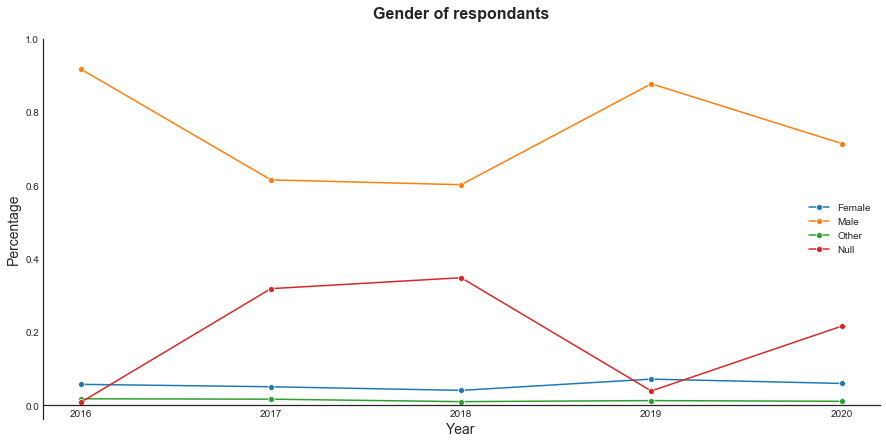

In [43]:
# Define function to plot gender overtime
def gender_time(df):
    """This function plots the evolution of participation
       by gender over time. It then saves the graph as a png
       file.
    """
    # Set figure size
    plt.figure(figsize=(15, 7))
    # Define graph for each gender category
    genders = ['gender_female', 'gender_male', 'gender_other', 'gender_null']
    for gender in genders:
        if gender in df.columns:
            sns.lineplot(x = 'year', y = gender, data = df, legend='brief', marker = 'o', label = gender.split('_')[1].capitalize())
    # Set details of plot
    plt.title('Gender of respondants', weight = 'bold', fontsize = 16, pad = 20)
    plt.xlabel("Year", fontsize = 14)
    plt.ylabel("Percentage", fontsize = 14)
    plt.xticks(df_gender['year'])
    plt.yticks([0,.2,.4, .6, .8, 1])
    plt.gca().spines['bottom'].set_position(('data',0))
    plt.legend(loc = 'center right', frameon = False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # Plot graph
    name = '../figures/gender_time_all.png' if 'gender_null' in df.columns else '../figures/gender_time_reduced.png'
    plt.savefig(name)
    
# Plot graph
gender_time(df_gender)

I looks like women have constantly been under 10% of the respondant pool. It is worth noting, however, that many people choose to not declare their gender. We might want to look at what the composition of male, female and other are only among those people who chose to declare their gender.

In [44]:
# Define gender adjusted dataset
df_gender_adj = df_gender[['year', 'gender_male', 'gender_female', 'gender_other']]

# Set sum of relevat variables
sum_gender = df_gender_adj[['gender_male', 'gender_female', 'gender_other']].sum(axis=1)

# Adjust categories by only those who declared their gender
df_gender_adj['gender_male'] = df_gender_adj['gender_male']/sum_gender
df_gender_adj['gender_female'] = df_gender_adj['gender_female']/sum_gender
df_gender_adj['gender_other'] = df_gender_adj['gender_other']/sum_gender

# Print adjusted gender distributions
df_gender_adj.head()

,year,gender_male,gender_female,gender_other
0,2016,0.924477,0.057604,0.017918
1,2017,0.901332,0.074186,0.024481
2,2018,0.922273,0.062433,0.015294
3,2019,0.912336,0.074280,0.013383
4,2020,0.910121,0.076033,0.013846


With this in hands we can reproduce the graph we did before.

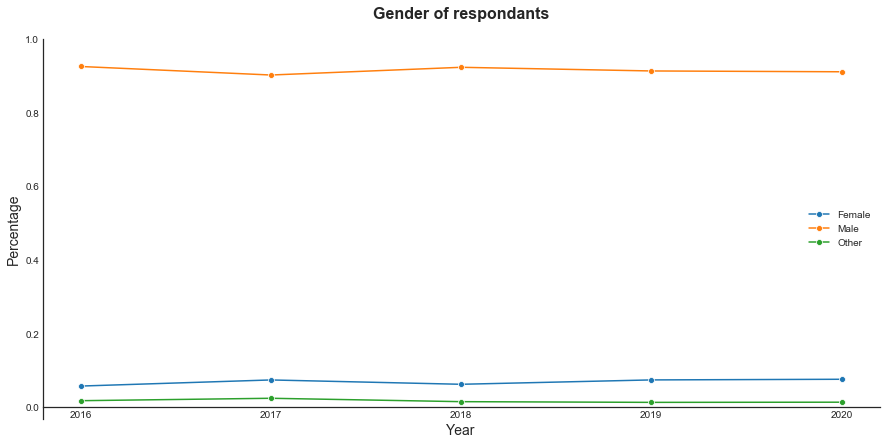

In [45]:
# Plot adjusted graph
gender_time(df_gender_adj)

This is no surprise as men did constitute the majority of respondants before. This exercise does indicate, however, that there is a lack of participation of women (and other gender identifications) in the Stack Overflow Annual Developer Survey, which could indicate a wider trend in the tech industry that needs to be addressed. Ideally we would want a higher participation of women in the tech industry.

Another interesting way to see how the participation of female respondants has change is through an animation. In order to do that let's pick 10 countries with over 1000 respondants and plot a bar chart race to see how the composition of female respondants from these countries has changed over the last 5 years. To begin, let's define a function to prepare the dataframes to the format that the packe [bar-chart-race](https://pypi.org/project/bar-chart-race/) requires.

In [46]:
# Define function to transpose and prepare dataframe for bar chart race
def bar_race_prep(df_):
    """This function transposes a dataframe with the appropriate
       variables in order to prepare it to be plot as a bar chart
       race for desired countries.
    """
    # Setup count dataframe and filter
    include_countries = ['United States', 'Canada', 'Russian Federation', 'United Kingdom',
                         'Germany', 'France', 'Netherlands', 'Brazil', 'Australia', 'India']
    df_filter = df_.loc[df_['country'].isin(include_countries)]
    # Get only desired variables and group by country
    df = df_filter[['country', 'gender_female']].groupby('country', as_index = False).mean()
    # Transpose and change index name
    df_T = df.set_index('country').transpose().reset_index(drop = True).rename_axis()
    df_T.index = [df_['year'].unique()[0]]
    df_T.index.name = 'year'
    # Return transposed dataframe
    return(df_T)

# Get transponsed prepared dataframes
bar_race_2020 = bar_race_prep(survey_2020)
bar_race_2019 = bar_race_prep(survey_2019)
bar_race_2018 = bar_race_prep(survey_2018)
bar_race_2017 = bar_race_prep(survey_2017)
bar_race_2016 = bar_race_prep(survey_2016)

# Merge all into one
df_list = [bar_race_2016, bar_race_2017, bar_race_2018,
           bar_race_2019, bar_race_2020]
df_bar = pd.concat(df_list)

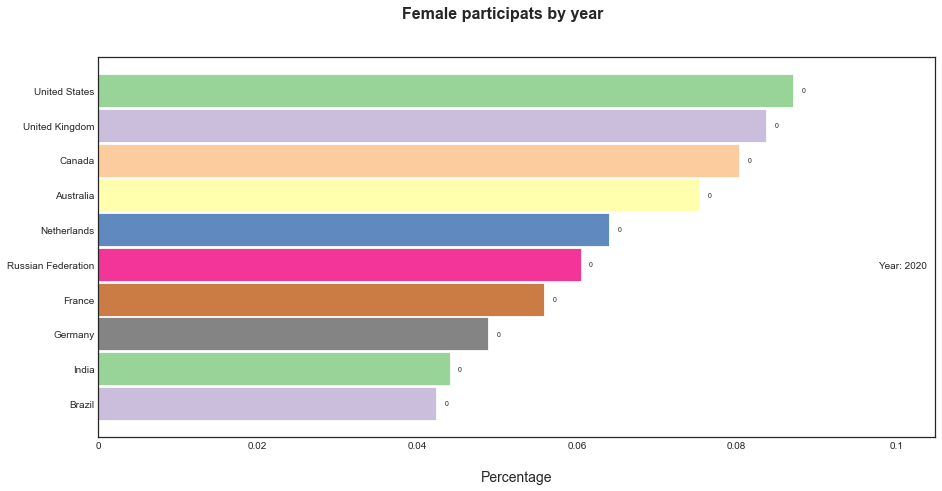

In [126]:
fig, ax = plt.subplots(1, figsize=(15, 7))
fig.suptitle('Female participats by year', fontsize = 16, weight = 'bold')
ax.set_xlabel('Percentage', fontsize = 14, labelpad = 20)
ax.set_xticklabels((0, 0.02, 0.04, 0.06, 0.08, 0.1))
bcr.bar_chart_race(df_bar, period_length = 1200, sort = 'desc',
                   interpolate_period = True, bar_size = .95,
                   period_label={'x': .99, 'y': .45, 'ha': 'right', 'va': 'center'},
                   cmap = 'accent',
                   fixed_max = True, fixed_order = True, n_bars = 10,
                   fig = fig, period_fmt = 'Year: {x:.0f}',
                   title='Percentage of female respondants')


That looks nice!

In [134]:
dff = survey_2018[['year', 'gender_female', 'gender_male', 'gender_other', 'gender_null', 'country']].groupby('country', as_index = False).mean()
include_countries = ['United States', 'Canada', 'Russian Federation', 'United Kingdom',
                         'Germany', 'France', 'Netherlands', 'Brazil', 'Australia', 'India']

dff = dff.loc[dff['country'].isin(include_countries)]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text yticklabel objects>)

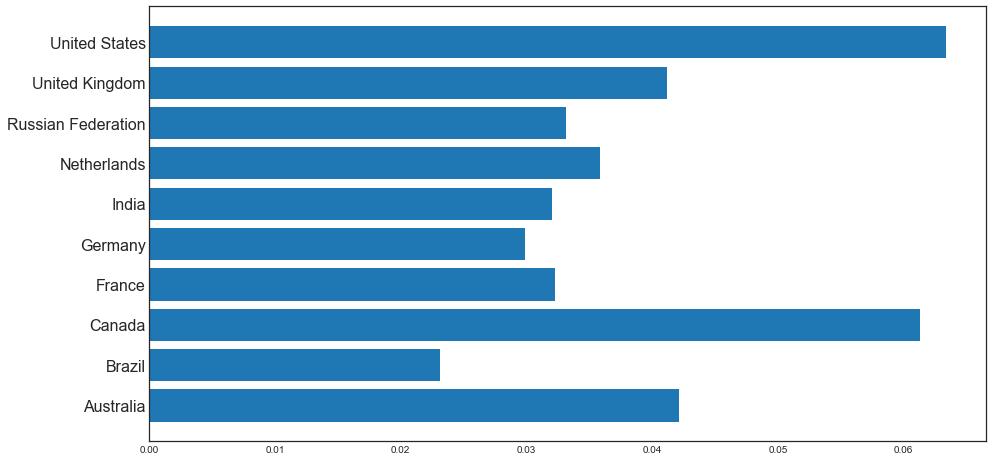

In [309]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.barh(dff['country'], dff['gender_female'])
plt.yticks(ha='right', fontsize=16)

In [184]:
colors = dict(zip(
    ['United States','Canada', 'Russian Federation', 'United Kingdom', 'Germany', 'France', 'Netherlands', 'Brazil', 'Australia', 'India'],
    ['#e48381' , '#e48381', '#adb0ff', '#adb0ff', '#adb0ff', '#adb0ff', '#adb0ff', '#90d595', '#b97bff', '#f7bb5f']
     ))
group_lk = dff.set_index('country').to_dict()
     
     

In [185]:
colors['United States']

'#e48381'

In [204]:
dd = 0.823723823

In [206]:
round(dd, 2)

0.82

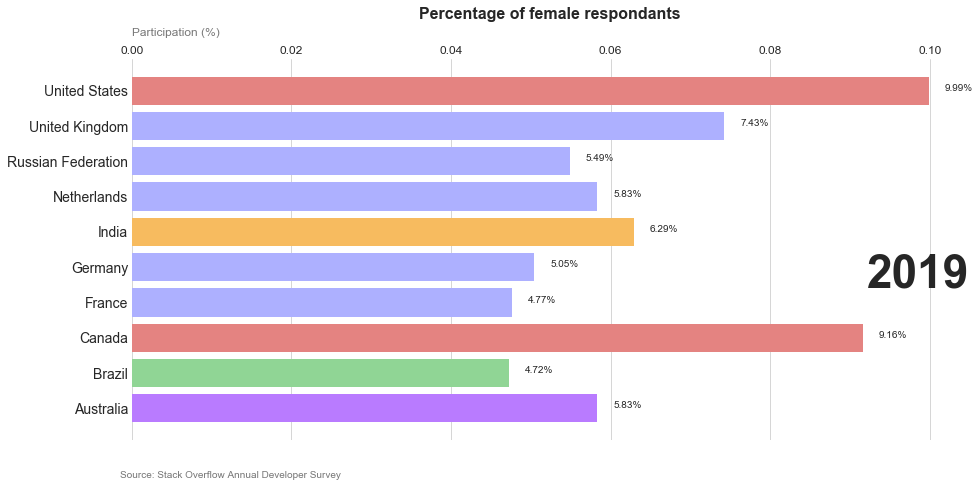

In [420]:
fig, ax = plt.subplots(figsize=(15, 7))
    
def draw_move(survey_):
    """This function plots a bar chart for selected
       countries for the dataframe passed as argument.
    """
    # Clear plot
    plt.cla()
    # Define what year dataframe refers to
    year = survey_['year'].unique()[0]
    # Filter only necessary data
    plot_df = survey_[['year', 'gender_female', 'country']].groupby('country', as_index = False).mean()
    # List countries to be looked at with colors to be matched to
    colors = dict(zip(['United States','Canada', 'Russian Federation', 'United Kingdom', 'Germany',
                       'France', 'Netherlands', 'Brazil', 'Australia', 'India'],
                      ['#e48381' , '#e48381', '#adb0ff', '#adb0ff', '#adb0ff', '#adb0ff', '#adb0ff',
                       '#90d595', '#b97bff', '#f7bb5f']))
    # Define dataframe with countries of interest
    plot_df = plot_df.loc[plot_df['country'].isin(colors.keys())]
    # Set colors and pass them
    group_lk = plot_df.set_index('country').to_dict()
    ax.barh(plot_df['country'], plot_df['gender_female'], color= [colors[x] for x in plot_df['country']])
    # Plot labels and values by iterating
    for i, (value, name) in enumerate(zip(plot_df['gender_female'], plot_df['country'])):
        ax.text(value + 0.002, i, str(round(100*float(value), 2)) + '%', ha = 'left')
    # Add title, axis name and legend
    plt.title('Percentage of female respondants', weight = 'bold', fontsize = 16, pad = 40)
    ax.text(0, 1.06, 'Participation (%)', transform=ax.transAxes, size=12, color='#777777')
    ax.text(0.25, -0.1, 'Source: Stack Overflow Annual Developer Survey', transform=ax.transAxes, ha='right',
                color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    # Add ticks and other details
    ax.text(1, 0.4, year, transform=ax.transAxes, size=46, ha='right', weight=800)
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', labelsize=12)
    ax.grid(which='major', axis='x', linestyle='-')
    plt.xticks([0, 0.02, 0.04, 0.06, 0.08, 0.1])
    plt.yticks(fontsize = 14)  
    plt.box(False)

draw_move(survey_2019)

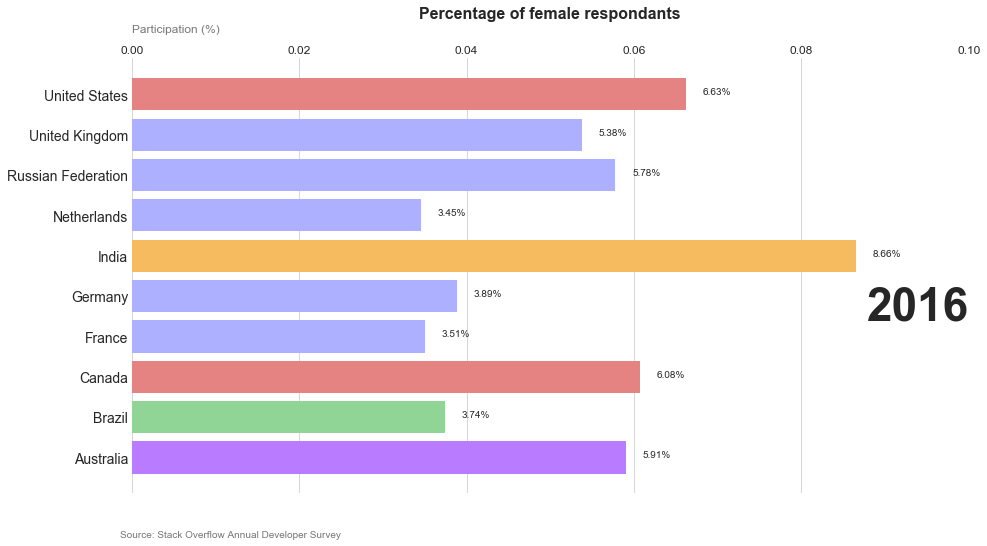

In [421]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_move, interval = 400,
                                   frames=[survey_2016, survey_2017, survey_2018, survey_2019, survey_2020])
HTML(animator.to_jshtml())

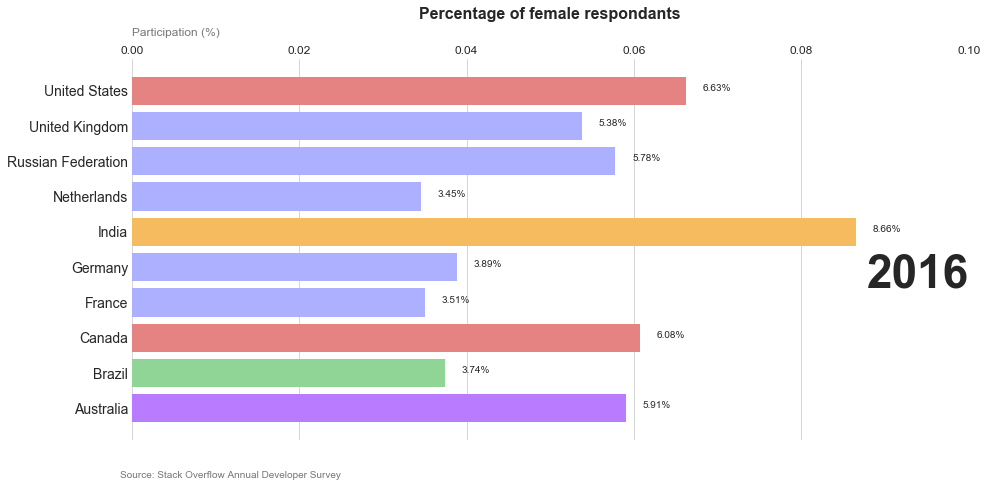

In [435]:
fig, ax = plt.subplots(figsize=(15, 7))
draw_move(survey_2016)
plt.savefig('../figures/female_participation_2016.png')

In [438]:
# List map files
files = ['../figures/female_participation_2016.png',
             '../figures/female_participation_2017.png',
             '../figures/female_participation_2018.png',
             '../figures/female_participation_2019.png',
             '../figures/female_participation_2020.png']

# Read with imageio
images = [imageio.imread(file) for file in files]

# Save gif
imageio.mimwrite('../figures/female_participation.gif', images, fps = 2)

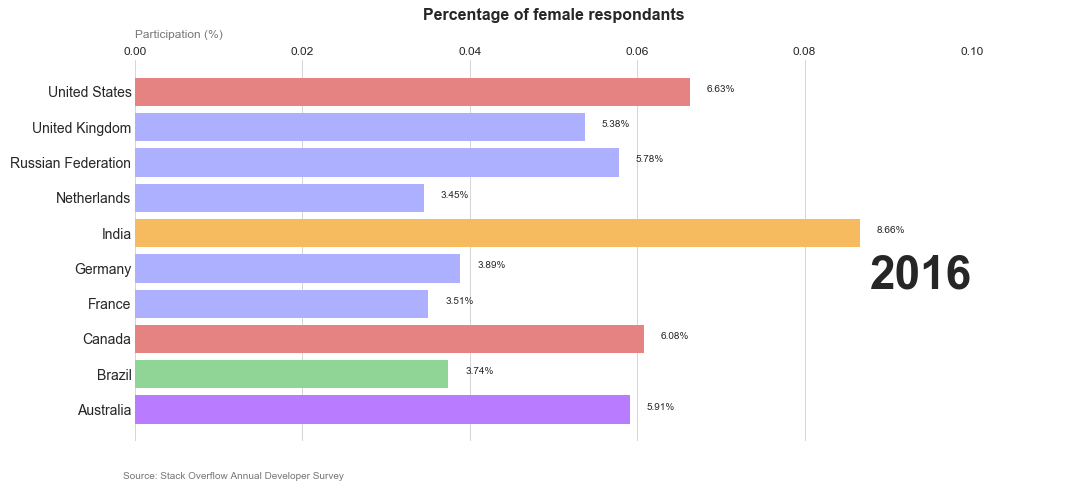

In [439]:
# Plot gif for all respondants
Image(open('../figures/female_participation.gif','rb').read())

In [417]:
#Image(url='animation.gif')

<a name="q2"></a>
### Are male respondants happier than female respondants?

Seeing that the majority of survey respondants are men, we could check if this translates into men having a higher job satisfaction than women and other gender identities.

<Figure size 1080x504 with 0 Axes>

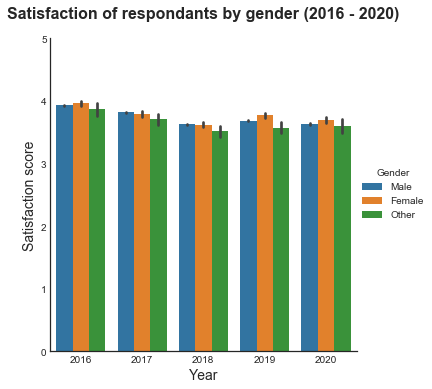

In [48]:
# Set figure size
plt.figure(figsize = (15, 7))

# Define graph for satisfaction per gender over years
g = sns.catplot(x = 'year', y = 'satisfaction_score', hue = 'gender', kind= 'bar', data = survey)
g._legend.set_title("Gender")
# Set details of plot
plt.title('Satisfaction of respondants by gender (2016 - 2020)', weight = 'bold', fontsize = 16, pad = 20)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Satisfaction score', fontsize = 14)
plt.yticks([0, 1, 2, 3, 4, 5]);

It doesn't look like there is a significantly difference in job satisfaction over the years between genders. Note, however, that it does seem that happiness levels were slightly higher in 2016 if compared to the other years. It is also interesting to observe that job satisfaction for female respondant does seem to be slightly higher than for males and people that self-identify with other genders tend to have a lower job satisfaction rate.

<a name="q3"></a>
### What countries have the highest job satisfaction rates?

Since we can plot a map with geopandas, it might be interesting to see how countries around world compare in terms of job satisfaction. In order to do this, we can create a function that organizes our data and plots a map of job satisfaction scores for every country around the world by employment category.

In [49]:
def plot_satisfaction_map(df, df_map, cat):
    """This function organizes the survey dataframe,
       merges it with map geopandas dataframe and filters
       for specific job category and plots a map.
    """
    # Filter employment category
    if cat == 'full-time':
        empl_filter = df[df.employment == 'Full-time']
    elif cat == 'part-time':
        empl_filter = df[df.employment == 'Part-time']
    else:
        empl_filter = df
    # Group data by country code with gender variables
    q3 = empl_filter[['satisfaction_score', 'country_numeric', 'year']].groupby('country_numeric', as_index = False).mean()
    # Join data with maps
    map_q3 = df_map.set_index('CNTRY_CODE').join(q3.set_index('country_numeric'))
    # Define year variable and plot name
    year = str(int(map_q3['year'].mean()))
    name = '../figures/job_satisfaction_map_{}_{}.png'.format(cat, year)
    # Get values for colorbar
    vmin, vmax, vcenter = 1, 5, 3
    divnorm = colors.DivergingNorm(vmin = vmin, vcenter = vcenter, vmax = vmax)
    # Create normalized colorbar
    cbar = plt.cm.ScalarMappable(norm=divnorm, cmap = 'YlGn')
    # Plot subplots and maps
    fig, ax = plt.subplots(1,figsize=(15, 7)) 
    map_q3.plot(ax = ax, color = 'grey') # Fill non-available grey
    map_q3.plot(column = 'satisfaction_score', cmap = 'YlGn', ax = ax)
    # Graph specifications
    plt.tight_layout()
    plt.title('Job satisfaction scores around the world for {} respondants'.format(cat), weight = 'bold', fontsize = 16, pad = 20)
    plt.annotate('Source: Stack Overflow Annual Developer Survey, {}'.format(year), xy = (0.05, 0.08),  xycoords = 'figure fraction', horizontalalignment = 'left', verticalalignment = 'top', fontsize = 12, color = '#555555')
    plt.annotate(r'Year: $\bf{' + year  + '}$', xy = (0.08, 0.5), xycoords = 'figure fraction', horizontalalignment = 'left', verticalalignment = 'top', fontsize = 14)
    fig.colorbar(cbar, ax = ax, shrink = 0.8)
    ax.set_axis_off()
    # Save plot
    plt.savefig(name)


Perfect! Now we can save these as png files in the figures folder.

In [ ]:
%%capture
# Save maps for each year for all respondants
plot_satisfaction_map(survey_2020, map_df, 'all')
plot_satisfaction_map(survey_2019, map_df, 'all')
plot_satisfaction_map(survey_2018, map_df, 'all')
plot_satisfaction_map(survey_2017, map_df, 'all')
plot_satisfaction_map(survey_2016, map_df, 'all')

# Save maps for each year for part-time respondants
plot_satisfaction_map(survey_2020, map_df, 'part-time')
plot_satisfaction_map(survey_2019, map_df, 'part-time')
plot_satisfaction_map(survey_2018, map_df, 'part-time')
plot_satisfaction_map(survey_2017, map_df, 'part-time')
plot_satisfaction_map(survey_2016, map_df, 'part-time')

# Save maps for each year for full-time respondants
plot_satisfaction_map(survey_2020, map_df, 'full-time')
plot_satisfaction_map(survey_2019, map_df, 'full-time')
plot_satisfaction_map(survey_2018, map_df, 'full-time')
plot_satisfaction_map(survey_2017, map_df, 'full-time')
plot_satisfaction_map(survey_2016, map_df, 'full-time')

We can look at what the graph would look like for one of the years. Let's see what 2020 for all workers looks like.

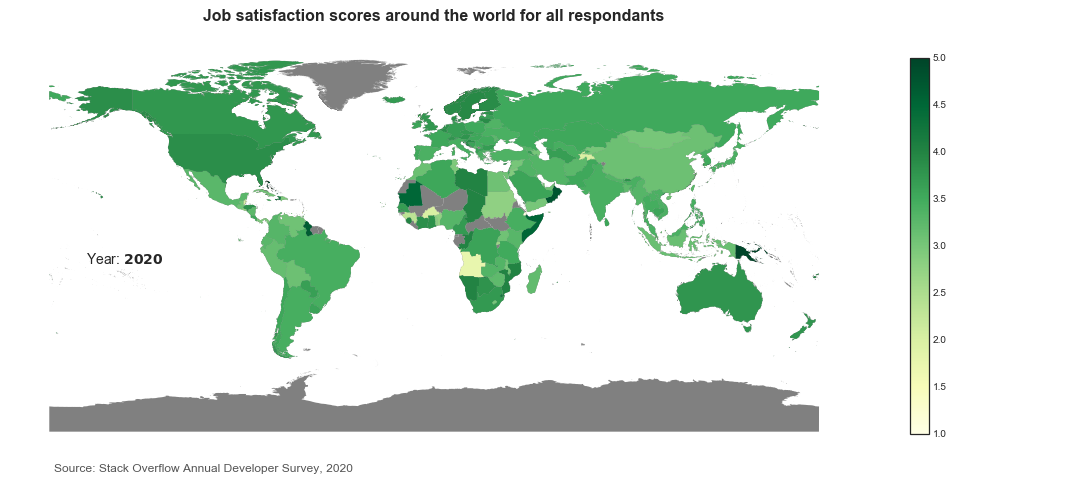

In [50]:
# Plot map for all respondant in 2020
Image(open('../figures/job_satisfaction_map_all_2020.png','rb').read())

This map is insteresting as it shows that there are a few outliers when it comes to job satisfaction. Now, we have to be careful when looking at this. Some countries might have very few respondants, which can cause the average job satisafction index to be pulled up or down very easily. Another problem with this is that it gives us a snapshot of the map at one point in time. In order to see how job satisfaction changes overtime we can make a gif with all the maps we created!

In [ ]:
# List map files
files_all = ['../figures/job_satisfaction_map_all_2016.png',
             '../figures/job_satisfaction_map_all_2017.png',
             '../figures/job_satisfaction_map_all_2018.png',
             '../figures/job_satisfaction_map_all_2019.png',
             '../figures/job_satisfaction_map_all_2020.png']
files_part = ['../figures/job_satisfaction_map_part-time_2016.png',
             '../figures/job_satisfaction_map_part-time_2017.png',
             '../figures/job_satisfaction_map_part-time_2018.png',
             '../figures/job_satisfaction_map_part-time_2019.png',
             '../figures/job_satisfaction_map_part-time_2020.png']
files_full = ['../figures/job_satisfaction_map_full-time_2016.png',
             '../figures/job_satisfaction_map_full-time_2017.png',
             '../figures/job_satisfaction_map_full-time_2018.png',
             '../figures/job_satisfaction_map_full-time_2019.png',
             '../figures/job_satisfaction_map_full-time_2020.png']

# Read with imageio
images_all = [imageio.imread(file) for file in files_all]
images_part = [imageio.imread(file) for file in files_part]
images_full = [imageio.imread(file) for file in files_full]

# Save gif
imageio.mimwrite('../figures/job_satisfaction_all.gif', images_all, fps = 1)
imageio.mimwrite('../figures/job_satisfaction_part.gif', images_part, fps = 1)
imageio.mimwrite('../figures/job_satisfaction_full.gif', images_full, fps = 1)

Let's take a look at what the gift looks like for an example year and job category 

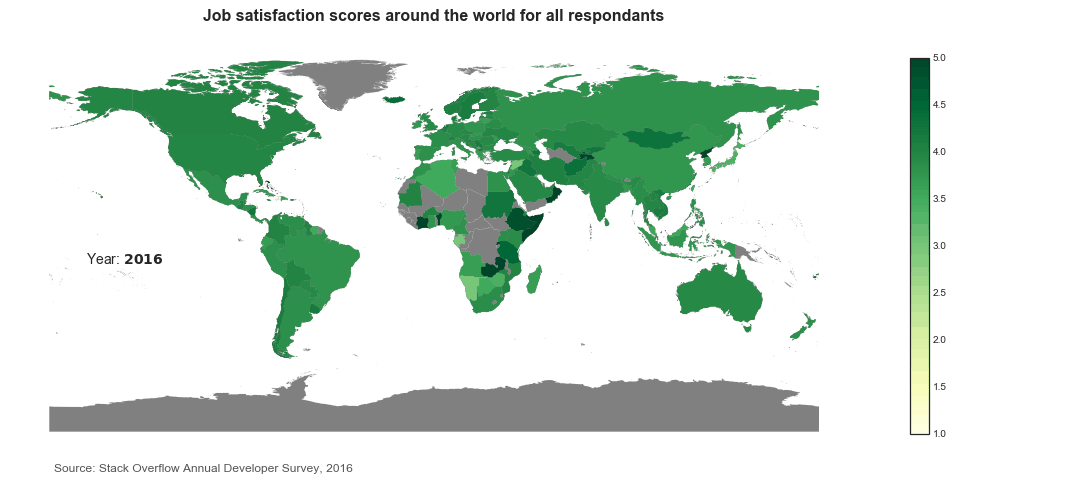

In [51]:
# Plot gif for all respondants
Image(open('../figures/job_satisfaction_all.gif','rb').read())

That is very interesting! We see that there is no clear trend of job satisfaction getting higher or lower. We see, however, that some regions tend to stay on the higher end of the job satisfaction spectrum (US and Canda and the Nordic countries are examples). Lastly, it looks like in 2017 somebody in Antarctica answered to the survey and was very happy with their job. Could that be true? Yes, maybe a happy coder moved to Antactica and is happy to work alongside pengiuns. However, most likely this was someone lying about where they live or checking Antarctica by mistake.

<a name="eval"></a>
## 5. Evaluate the results

Text text

<a name="deploy"></a>
## 6. Deploy

Text text